In [2]:
!pip install timm
!pip install albumentaions

ERROR: Could not find a version that satisfies the requirement albumentaions (from versions: none)
ERROR: No matching distribution found for albumentaions


In [3]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import timm
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch import nn
from tqdm import tqdm
import random

# Dataset

In [22]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_dir, trainTest_dir, classesIdx_txt, mode = 'train', num_classes = 5,
                     num_frames = 50, transform = None, target_transform = None):
        super().__init__()
        
        self.video_dir = video_dir
        self.trainTest_dir = trainTest_dir
        self.classIndx_txt = classesIdx_txt
        self.mode = mode.strip().lower()
        
        assert self.mode in ['train', 'test']
        
        self.transform = transform
        self.target_transform = target_transform
        self.num_classes = num_classes
        
        self.num_frames = num_frames
        
        self.class_dict = {}
        with open(self.classIndx_txt, 'r') as f:
            for line in f.readlines():
                classIdx, classLabel = line.split()
                self.class_dict[classLabel] = int(classIdx)
        
        self.video_filename_list = []
        self.classesIdx_list = []
        
        for trainTest_filename in os.listdir(self.trainTest_dir):
            if self.mode in trainTest_filename:
                path_txt = os.path.join(self.trainTest_dir, trainTest_filename)
                video_filename, classesIdx = self.read_traintest_txt(path_txt)
                self.video_filename_list = self.video_filename_list + video_filename
                self.classesIdx_list = self.classesIdx_list + classesIdx
        
    def __len__(self):
        return len(self.video_filename_list)
        
    def read_traintest_txt(self, path):
        video_filename = []
        classIdx = []
        with open(path, 'r') as f:
            for line in f.readlines():
                if self.mode == 'train':
                    filename, Idx = line.split()
                    if int(Idx) < self.num_classes:
                        video_filename.append(filename)
                        classIdx.append(int(Idx))
                elif self.mode == 'test':
                    filename = line
                    classLabel = filename.split('/')[0]
                    Idx = self.class_dict[classLabel]
                    if int(Idx) < self.num_classes:
                        video_filename.append(filename)
                        classIdx.append(int(Idx))
                    
        return video_filename, classIdx
                    
    def read_video(self, video_path):
        frames = []
        cap = cv.VideoCapture(video_path)
        count_frames = 0
        while True:
            ret, frame = cap.read()
            if ret:
                if self.transform:
                    transformed = self.transform(image = frame)
                    frame = transformed['image']
                    
                frames.append(frame)
                count_frames += 1
            else: 
                break
        
        stride = count_frames // self.num_frames
        new_frames = []
        count = 0
        for i in range(0, count_frames, stride):
            if count >= self.num_frames:
                break
            new_frames.append(frames[i])
            count += 1
            
        cap.release()
        
        return torch.stack(new_frames, dim = 0)
    
    def __getitem__(self, idx):
        classIdx = self.classesIdx_list[idx]
        classLabel = self.class_dict[classIdx]
        video_filename = self.video_filename_list[idx]
        video_path = os.path.join(self.video_dir, video_filename)
                
        frames = self.read_video(video_path)
        
        return frames, classIdx - 1
    
    

# Split dataloader

In [5]:
def split_dataloader(train_data, validation_split = 0.2):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    
    return train_data, val_data

# Evaluate function

In [24]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model = model.to(device)

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    with torch.no_grad():
        model.eval()
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data_batch, label_batch in val_data:
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)

            # tính toán đầu ra cho bộ valid
            output_batch = model(data_batch)

            loss = loss_fn(output_batch, label_batch.long())
            running_loss += loss.item()

            # dự đoán đầu ra với softmax
            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            val_correct += (label_batch == predicted_labels).sum().item()
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total
        return val_loss, val_acc


# Train function

In [7]:
def train(model, train_data, loss_fn, optimizer, epochs, weights = None, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', validation_data = None, validation_split = None, scheduler = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)
    
    # nếu truyền vào model trọng số có sẵn, thì nó sẽ lưu trọng số lại 
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
        
    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None
        
    # save best model
    if save_best_weights_path: 
        if val_data is None:
            train_data, val_data = split_dataloader(train_data, 0.2)
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn)  
        
    # đặt số lần update weights trong 1 epoch
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
    
    ## History
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):
        # tính tổng giá trị hàm mất mát cho mỗi epoch
        running_loss = 0.
        train_correct = 0
        train_total = steps_per_epoch*train_data.batch_size
        
        # đặt model ở chế độ huấn luyện 
        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            
            # Xóa các gradient
            optimizer.zero_grad()
            
            # tính toán đầu ra
            output_batch = model(img_batch)
            
            # tính loss
            loss = loss_fn(output_batch, label_batch.long())
            
            # lan truyền ngược
            loss.backward()
            
            # cập nhật trọng số cho mạng
            optimizer.step()
            
            # dự đoán đầu ra với softmax
            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            train_correct += (label_batch == predicted_labels).sum().item()
                
            # Cập nhật tổng hàm mất mát
            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
            
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct/train_total
        
        # reduce lr
        if scheduler:
            scheduler.step(train_loss)
        
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history


# Conv + LSTM 

In [8]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes, hidden_size, num_lstm_layers = 2, backbone_name = 'resnet101'):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained = True, features_only = True)
        self.adap = nn.AdaptiveAvgPool2d((2,2))
        
        self.lstm = nn.LSTM(2048, hidden_size, num_lstm_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        'x: batch, num_frames, channels, height, width'
        batch, num_frames, channels, height, width = x.shape
        
        # x: batch * num_frames, channels, height, width 
        x = torch.reshape(x, (-1, *x.shape[2:]))
        
        x1,x2,x3,x4,x5 = self.backbone(x)
        
        # x: batch * num_frames, 512, 2, 2
        x = self.adap(x3)
        
        # x: batch * num_frames, 2048
        x = nn.Flatten()(x)
        
        # x: batch, num_frames, features vector 
        x = torch.reshape(x, (batch, num_frames, -1))
        
        # x: Tensor kích thước (batch_size, sequence_length, hidden_size)
        # h_n: Hidden state cuối cùng của lớp cuối cùng, kích thước (num_layers, batch_size, hidden_size)
        # c_n: Cell state cuối cùng của lớp cuối cùng, kích thước (num_layers, batch_size, hidden_size)
        x, (h_n, c_n) = self.lstm(x)
        
        x = h_n[-1, ...]
        
        x = self.fc(x)
        
        return x

# Visualize history

In [9]:
def visualize_history(history, metrics = ['acc', 'loss']):   
    
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

# Parameters

In [10]:
classesIdx = '/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt'
trainTest_dir = '/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist'
mode = 'train'
video_dir = '/kaggle/input/ucf101/UCF101/UCF-101'
last_weights = 'last_weights.pt'
best_weights = 'best_weights.pt'

num_classes = 5
batch_size = 4
num_frames = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (120,160)
num_workers = os.cpu_count()
hidden_size = 128
num_lstm_layers = 2

# Transform and train dataloader

In [11]:
transform = A.Compose(
    [
        A.Resize(height = img_size[0], width = img_size[1]),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = VideoDataset(video_dir, trainTest_dir, classesIdx, mode = 'train', num_frames = num_frames, num_classes = num_classes, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)


# Create model

In [12]:
model = ClassificationModel(num_classes = num_classes, hidden_size = hidden_size, 
                            num_lstm_layers = num_lstm_layers, backbone_name = 'resnet101')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'min', patience = 3, verbose = 1)

# Train model

In [13]:
model, history = train(model, train_dataloader, loss_fn, optimizer, weights = None, epochs = 50,
              save_last_weights_path = last_weights, save_best_weights_path = best_weights,
              device = device, validation_split = 0.2, steps_per_epoch = 100, scheduler = scheduler)


epoch: 1/50: 100%|████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


epoch: 1, train_accuracy:  0.35, loss:  1.442, val_accuracy:  0.04, val_loss: 1.551
Saved successfully best weights to: best_weights.pt


epoch: 2/50: 100%|████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


epoch: 2, train_accuracy:  0.45, loss:  1.240, val_accuracy:  0.50, val_loss: 1.198
Saved successfully best weights to: best_weights.pt


epoch: 3/50: 100%|████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


epoch: 3, train_accuracy:  0.59, loss:  1.054, val_accuracy:  0.61, val_loss: 0.959
Saved successfully best weights to: best_weights.pt


epoch: 4/50: 100%|████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


epoch: 4, train_accuracy:  0.55, loss:  0.948, val_accuracy:  0.44, val_loss: 0.827
Saved successfully best weights to: best_weights.pt


epoch: 5/50: 100%|████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


epoch: 5, train_accuracy:  0.61, loss:  0.854, val_accuracy:  0.75, val_loss: 0.742
Saved successfully best weights to: best_weights.pt


epoch: 6/50: 100%|████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


epoch: 6, train_accuracy:  0.62, loss:  0.764, val_accuracy:  0.75, val_loss: 0.582
Saved successfully best weights to: best_weights.pt


epoch: 7/50: 100%|████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


epoch: 7, train_accuracy:  0.66, loss:  0.741, val_accuracy:  0.75, val_loss: 0.502
Saved successfully best weights to: best_weights.pt


epoch: 8/50: 100%|████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.96it/s]


epoch: 8, train_accuracy:  0.69, loss:  0.713, val_accuracy:  0.66, val_loss: 0.666


epoch: 9/50: 100%|████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


epoch: 9, train_accuracy:  0.71, loss:  0.696, val_accuracy:  0.73, val_loss: 0.554


epoch: 10/50: 100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


epoch: 10, train_accuracy:  0.79, loss:  0.549, val_accuracy:  0.89, val_loss: 0.369
Saved successfully best weights to: best_weights.pt


epoch: 11/50: 100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.05it/s]


epoch: 11, train_accuracy:  0.79, loss:  0.513, val_accuracy:  0.87, val_loss: 0.365
Saved successfully best weights to: best_weights.pt


epoch: 12/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  2.00it/s]


epoch: 12, train_accuracy:  0.83, loss:  0.499, val_accuracy:  0.85, val_loss: 0.362
Saved successfully best weights to: best_weights.pt


epoch: 13/50: 100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


epoch: 13, train_accuracy:  0.89, loss:  0.374, val_accuracy:  0.96, val_loss: 0.199
Saved successfully best weights to: best_weights.pt


epoch: 14/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


epoch: 14, train_accuracy:  0.92, loss:  0.296, val_accuracy:  0.86, val_loss: 0.318


epoch: 15/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


epoch: 15, train_accuracy:  0.88, loss:  0.358, val_accuracy:  0.97, val_loss: 0.165
Saved successfully best weights to: best_weights.pt


epoch: 16/50: 100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


epoch: 16, train_accuracy:  0.83, loss:  0.496, val_accuracy:  0.82, val_loss: 0.572


epoch: 17/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


epoch: 17, train_accuracy:  0.94, loss:  0.275, val_accuracy:  0.96, val_loss: 0.185


epoch: 18/50: 100%|███████████████████████████████████████████████| 100/100 [00:47<00:00,  2.08it/s]


epoch: 18, train_accuracy:  0.90, loss:  0.321, val_accuracy:  0.91, val_loss: 0.277


epoch: 19/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


epoch: 19, train_accuracy:  0.97, loss:  0.160, val_accuracy:  0.96, val_loss: 0.163
Saved successfully best weights to: best_weights.pt


epoch: 20/50: 100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


epoch: 20, train_accuracy:  0.90, loss:  0.298, val_accuracy:  0.94, val_loss: 0.204


epoch: 21/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


epoch: 21, train_accuracy:  0.96, loss:  0.151, val_accuracy:  0.94, val_loss: 0.225


epoch: 22/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


epoch: 22, train_accuracy:  0.97, loss:  0.103, val_accuracy:  0.94, val_loss: 0.173


epoch: 23/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


epoch: 23, train_accuracy:  0.97, loss:  0.121, val_accuracy:  0.99, val_loss: 0.069
Saved successfully best weights to: best_weights.pt


epoch: 24/50: 100%|███████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


epoch: 24, train_accuracy:  0.99, loss:  0.067, val_accuracy:  1.00, val_loss: 0.030
Saved successfully best weights to: best_weights.pt


epoch: 25/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


epoch: 25, train_accuracy:  0.95, loss:  0.174, val_accuracy:  0.74, val_loss: 0.596


epoch: 26/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


epoch: 26, train_accuracy:  0.91, loss:  0.279, val_accuracy:  0.94, val_loss: 0.134


epoch: 27/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.96it/s]


epoch: 27, train_accuracy:  0.95, loss:  0.143, val_accuracy:  0.99, val_loss: 0.055


epoch: 28/50: 100%|███████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


epoch: 28, train_accuracy:  0.99, loss:  0.057, val_accuracy:  1.00, val_loss: 0.026
Saved successfully best weights to: best_weights.pt


epoch: 29/50: 100%|███████████████████████████████████████████████| 100/100 [00:53<00:00,  1.89it/s]


epoch: 29, train_accuracy:  1.00, loss:  0.034, val_accuracy:  1.00, val_loss: 0.035


epoch: 30/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


epoch: 30, train_accuracy:  0.93, loss:  0.189, val_accuracy:  1.00, val_loss: 0.152


epoch: 31/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


epoch: 31, train_accuracy:  0.99, loss:  0.065, val_accuracy:  0.99, val_loss: 0.057


epoch: 32/50: 100%|███████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


epoch: 32, train_accuracy:  0.99, loss:  0.034, val_accuracy:  0.99, val_loss: 0.041


epoch: 33/50: 100%|███████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]

Epoch 00033: reducing learning rate of group 0 to 1.0000e-05.


epoch: 33, train_accuracy:  0.96, loss:  0.113, val_accuracy:  0.95, val_loss: 0.190


epoch: 34/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


epoch: 34, train_accuracy:  0.99, loss:  0.059, val_accuracy:  1.00, val_loss: 0.038


epoch: 35/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


epoch: 35, train_accuracy:  0.99, loss:  0.040, val_accuracy:  1.00, val_loss: 0.031


epoch: 36/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


epoch: 36, train_accuracy:  0.99, loss:  0.040, val_accuracy:  1.00, val_loss: 0.025
Saved successfully best weights to: best_weights.pt


epoch: 37/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]

Epoch 00037: reducing learning rate of group 0 to 1.0000e-06.


epoch: 37, train_accuracy:  0.99, loss:  0.042, val_accuracy:  1.00, val_loss: 0.022
Saved successfully best weights to: best_weights.pt


epoch: 38/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


epoch: 38, train_accuracy:  1.00, loss:  0.023, val_accuracy:  1.00, val_loss: 0.022


epoch: 39/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


epoch: 39, train_accuracy:  1.00, loss:  0.022, val_accuracy:  1.00, val_loss: 0.022


epoch: 40/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


epoch: 40, train_accuracy:  1.00, loss:  0.027, val_accuracy:  1.00, val_loss: 0.023


epoch: 41/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


epoch: 41, train_accuracy:  1.00, loss:  0.024, val_accuracy:  1.00, val_loss: 0.022
Saved successfully best weights to: best_weights.pt


epoch: 42/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


epoch: 42, train_accuracy:  1.00, loss:  0.024, val_accuracy:  1.00, val_loss: 0.022


epoch: 43/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


epoch: 43, train_accuracy:  1.00, loss:  0.021, val_accuracy:  1.00, val_loss: 0.021
Saved successfully best weights to: best_weights.pt


epoch: 44/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


epoch: 44, train_accuracy:  1.00, loss:  0.023, val_accuracy:  1.00, val_loss: 0.021


epoch: 45/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


epoch: 45, train_accuracy:  1.00, loss:  0.021, val_accuracy:  1.00, val_loss: 0.021


epoch: 46/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


epoch: 46, train_accuracy:  1.00, loss:  0.021, val_accuracy:  1.00, val_loss: 0.020
Saved successfully best weights to: best_weights.pt


epoch: 47/50: 100%|███████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


epoch: 47, train_accuracy:  1.00, loss:  0.024, val_accuracy:  1.00, val_loss: 0.020


epoch: 48/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


epoch: 48, train_accuracy:  1.00, loss:  0.019, val_accuracy:  1.00, val_loss: 0.020
Saved successfully best weights to: best_weights.pt


epoch: 49/50: 100%|███████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


epoch: 49, train_accuracy:  0.99, loss:  0.030, val_accuracy:  1.00, val_loss: 0.020
Saved successfully best weights to: best_weights.pt


epoch: 50/50: 100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


epoch: 50, train_accuracy:  1.00, loss:  0.022, val_accuracy:  1.00, val_loss: 0.021
Saved successfully last weights to: last_weights.pt


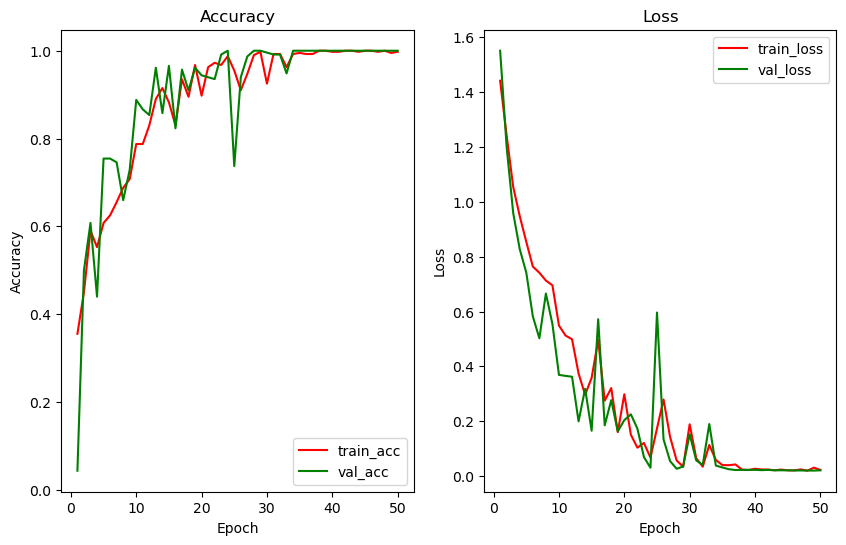

In [14]:
visualize_history(history)

# Transform and test data loader

In [23]:
transform = A.Compose(
    [
        A.Resize(height = img_size[0], width = img_size[1]),
        A.Normalize(),
        ToTensorV2()
    ]
)

test_dataset = VideoDataset(video_dir, trainTest_dir, classesIdx, mode = 'test', num_frames = num_frames, num_classes = num_classes, transform = transform)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last = True, num_workers = num_workers)


# Test Model

In [27]:
test_loss, test_acc = evaluate(model, weights = last_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Weights loaded successfully from path: last_weights.pt


Evaluate: 100%|███████████████████████████████████████████████████| 291/291 [02:04<00:00,  2.33it/s]

Loss:  0.033, Acc:  0.995


In [28]:
test_loss, test_acc = evaluate(model, weights = best_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Weights loaded successfully from path: best_weights.pt


Evaluate: 100%|███████████████████████████████████████████████████| 291/291 [02:03<00:00,  2.35it/s]

Loss:  0.017, Acc:  1.000
